# Exploratory Data Analysis

This notebook examines how critic and user ratings relate to price, and splits the data into indie and non-indie subsets to compare rating patterns across both groups. Distribution analysis on user scores was carried out in notebook 3.

In [4]:
import pandas as pd
df = pd.read_csv('../datasets/combined_filtered_genres.csv')

## User Score vs Critic Score and Steam Reviews

A reusable function that produces two scatter plots side by side: Metacritic user score against critic score, and against Steam positive review percentage. Called separately for the full dataset, indie games, and non-indie games.

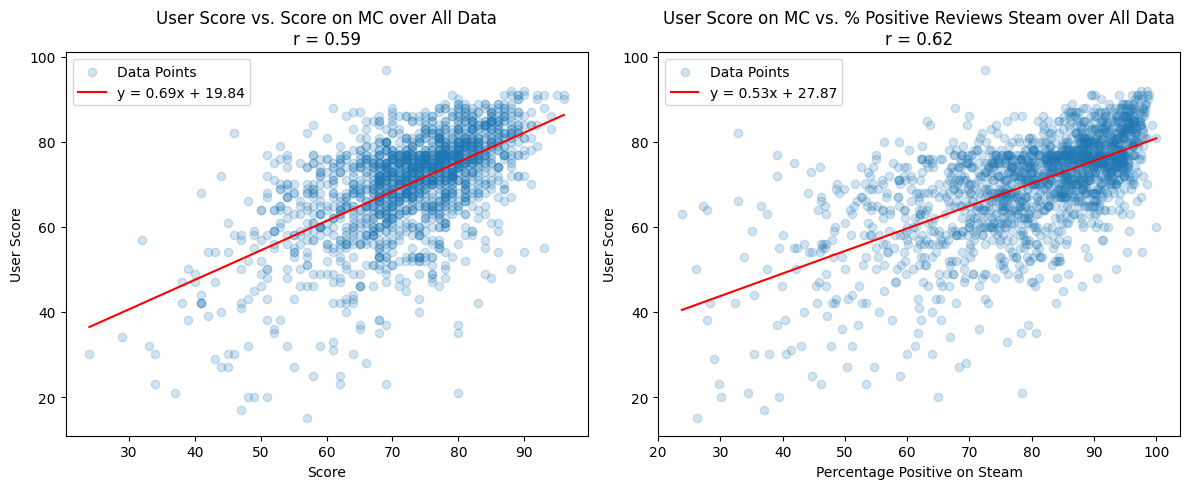

Equation 1: y = 0.69x + 19.84, r = 0.59
Equation 2: y = 0.53x + 27.87, r = 0.62


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def user_vs_critics(df, df_name):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    x1 = df['score']
    y1 = df['user score']
    slope1, intercept1, r_value1, _, _ = linregress(x1, y1)
    x_fit1 = np.linspace(min(x1), max(x1), 100)
    y_fit1 = slope1 * x_fit1 + intercept1

    axes[0].scatter(x1, y1, alpha=0.2, label="Data Points")
    axes[0].plot(x_fit1, y_fit1, color="red", label=f"y = {slope1:.2f}x + {intercept1:.2f}")
    axes[0].set_xlabel("Score")
    axes[0].set_ylabel("User Score")
    axes[0].set_title(f"User Score vs. Score on MC over {df_name}\nr = {r_value1:.2f}")
    axes[0].legend()

    # Scatter Plot 2: user_score vs. percentage_positive
    x2 = df['percent_positive_steam']*100
    y2 = df['user score']
    slope2, intercept2, r_value2, _, _ = linregress(x2, y2)
    x_fit2 = np.linspace(min(x2), max(x2), 100)
    y_fit2 = slope2 * x_fit2 + intercept2

    axes[1].scatter(x2, y2, alpha=0.2, label="Data Points")
    axes[1].plot(x_fit2, y_fit2, color="red", label=f"y = {slope2:.2f}x + {intercept2:.2f}")
    axes[1].set_xlabel("Percentage Positive on Steam")
    axes[1].set_ylabel("User Score")
    axes[1].set_title(f"User Score on MC vs. % Positive Reviews Steam over {df_name}\nr = {r_value2:.2f}")
    axes[1].legend()
    filename = f"{df_name}_user_vs_score.png"
    plt.savefig(f"../graphs/{filename}", dpi=300, bbox_inches="tight")

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Print equations and correlation values
    print(f"Equation 1: y = {slope1:.2f}x + {intercept1:.2f}, r = {r_value1:.2f}")
    print(f"Equation 2: y = {slope2:.2f}x + {intercept2:.2f}, r = {r_value2:.2f}")
    return None

user_vs_critics(df, 'All Data')

## Price vs Rating Difference

Scatter plot of price against the difference between critic and user scores. A regression line and the mean difference are overlaid to check whether more expensive games tend to be rated differently by critics vs users.

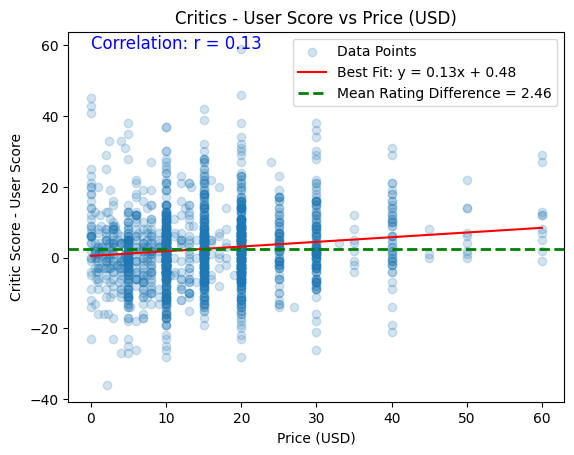

Equation of best fit: y = 0.13x + 0.48
Correlation coefficient (r): 0.13


In [6]:
x = df['price']
y = df['score'] - df['user score']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept
y_mean = np.mean(y)

plt.scatter(x, y, alpha=0.2, label="Data Points")


plt.plot(x_fit, y_fit, color="red", label=f"Best Fit: y = {slope:.2f}x + {intercept:.2f}")
plt.text(min(x), max(y), f"Correlation: r = {r_value:.2f}", fontsize=12, color="blue")
plt.axhline(y_mean, color="green", linestyle="dashed", linewidth=2, label=f"Mean Rating Difference = {y_mean:.2f}")

plt.xlabel("Price (USD)")
plt.ylabel("Critic Score - User Score")
plt.title("Critics - User Score vs Price (USD)")
plt.legend()
plt.savefig("../datasets/User + Critc Score vs. Price.png", dpi=300, bbox_inches="tight")

plt.show()

print(f"Equation of best fit: y = {slope:.2f}x + {intercept:.2f}")
print(f"Correlation coefficient (r): {r_value:.2f}")

## Pearson Correlation and Fisher Z-Test

A function that computes Pearson correlations between price and both score types, then uses a Fisher Z-transformation to test whether the two correlations are significantly different from each other. This is a two-tailed test on the transformed Z-scores.

In [7]:
import scipy.stats as stats
import numpy as np

def fisher_z(r):
    return 0.5 * np.log((1 + r) / (1 - r))

def pearson_fisher(df):
    price = df['price']
    user_score = df['user score']
    score = df['score']

    corr_price_user, p_value_user = stats.pearsonr(price, user_score)
    print(f"Pearson correlation between price and user score: {corr_price_user:.3f}, p-value: {p_value_user}")

    corr_price_score, p_value_score = stats.pearsonr(price, score)
    print(f"Pearson correlation between price and critic score: {corr_price_score:.3f}, p-value: {p_value_score}")
    z_user = fisher_z(corr_price_user)
    z_score = fisher_z(corr_price_score)

    # Standard error of the difference in Z-scores
    n = len(df)  # Number of observations (make sure the same number for both)
    se = np.sqrt((1 / (n - 3)) + (1 / (n - 3)))

    # Z-test for difference in correlations
    z_diff = (z_user - z_score) / se
    p_value_diff = 2 * (1 - stats.norm.cdf(abs(z_diff)))

    print(f"Z-score for the difference in correlations: {z_diff}")
    print(f"P-value for the difference in correlations: {p_value_diff}")
    return ([corr_price_user, p_value_user, corr_price_score, p_value_score], z_diff, p_value_diff)

### All Data

In [8]:
hyp_test_all = pearson_fisher(df)

Pearson correlation between price and user score: 0.023, p-value: 0.3395184598696748
Pearson correlation between price and critic score: 0.157, p-value: 6.603622352546462e-11
Z-score for the difference in correlations: -3.9505851186573215
P-value for the difference in correlations: 7.796036507268234e-05


## Indie vs Non-Indie Split

The dataset is split on whether a game's genre includes 'Indie'. The same scatter plots and hypothesis tests are then run on each subset to see whether the patterns hold across both groups.

Indie games represent small, independent studios whose commercial success is more precarious than larger publishers, making understanding what drives their ratings and reception particularly valuable.

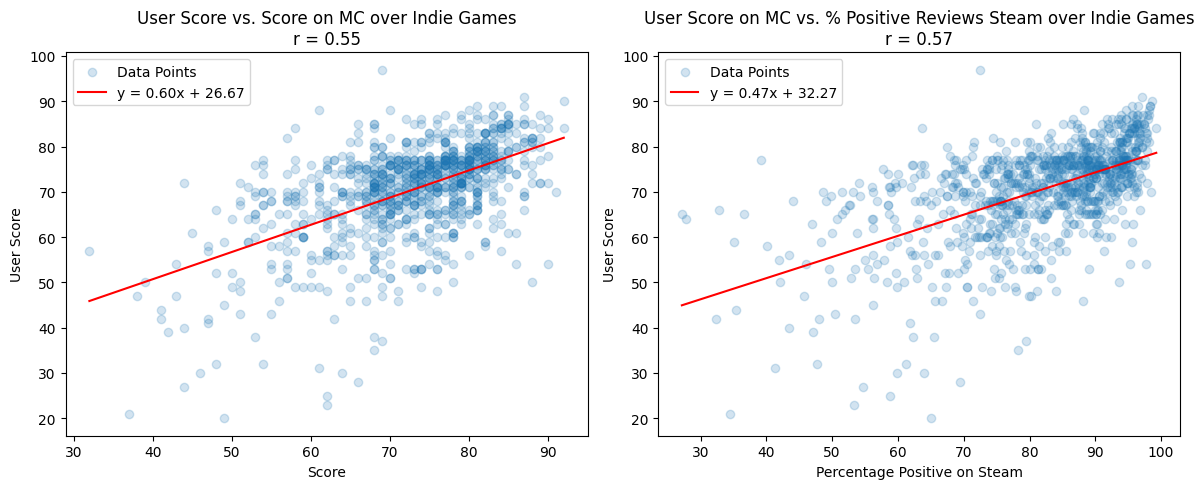

Equation 1: y = 0.60x + 26.67, r = 0.55
Equation 2: y = 0.47x + 32.27, r = 0.57


In [9]:
df.rename(columns={'Combined_Genres': 'genre'}, inplace=True)

df_indie = df[df['genre'].str.contains('Indie', case=False, na=False)]
df_non_indie = df[~df['genre'].str.contains('Indie', case=False, na=False)]

user_vs_critics(df_indie, 'Indie Games')
# print("Indie Genre DataFrame:")
# print(df_indie.head())
# print("\nNon-Indie Genre DataFrame:")
# print(df_non_indie.head())

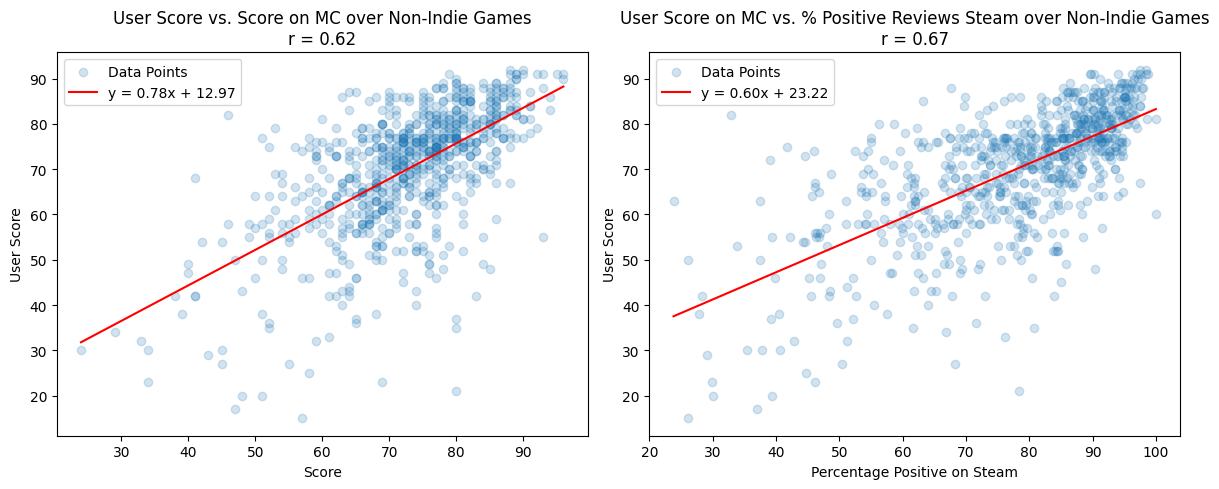

Equation 1: y = 0.78x + 12.97, r = 0.62
Equation 2: y = 0.60x + 23.22, r = 0.67


In [10]:
user_vs_critics(df_non_indie, 'Non-Indie Games')

### Hypothesis Tests by Subset

In [11]:
hyp_test_indie = pearson_fisher(df_indie)

Pearson correlation between price and user score: 0.025, p-value: 0.4389042289227329
Pearson correlation between price and critic score: 0.142, p-value: 1.1473065434309838e-05
Z-score for the difference in correlations: -2.5595348173730272
P-value for the difference in correlations: 0.01048123561627623


In [12]:
hyp_test_non_indie = pearson_fisher(df_non_indie)

Pearson correlation between price and user score: 0.023, p-value: 0.52717288126699
Pearson correlation between price and critic score: 0.171, p-value: 2.095500746422082e-06
Z-score for the difference in correlations: -2.9147003669636042
P-value for the difference in correlations: 0.00356030183977607
